In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../pipeline/src")
import pickle
import torch
from tqdm import tqdm

In [15]:
from utils.metrics import ContactPredictionMetrics
from datamodules.dataset import ProteinSequenceDataset

In [16]:
dataset = ProteinSequenceDataset.load_from_disk("../../pipeline/output/datasets/val.pt")
with open("../../pipeline/output/predictions/val.pkl", "rb") as f:
    predictions = pickle.load(f)

scorer = ContactPredictionMetrics()

In [17]:
predictions[0]

{'contact_logits': tensor([[[24.6216, 21.6234, 10.9762,  ..., -2.0631, -2.0707, -1.7077],
          [21.6234, 11.1691, 19.8142,  ..., -2.2973, -2.2428, -2.1169],
          [10.9762, 19.8142,  9.9750,  ..., -2.3351, -2.2971, -2.1838],
          ...,
          [-2.0631, -2.2973, -2.3351,  ..., 10.5900, 19.0575, 14.2203],
          [-2.0707, -2.2428, -2.2971,  ..., 19.0575, 10.6603, 20.4905],
          [-1.7077, -2.1169, -2.1838,  ..., 14.2203, 20.4905, 16.0466]]]),
 'mask_2d': tensor([[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]),
 'metadata': [{'id': 'train_1A77_A',
   'pdb_id': '1A77',
   'chain_id': 'A',
   'length': 315,
   'residue_indices': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,

In [18]:
id_prediction_map = {pred["metadata"][0]["id"]: pred for pred in predictions}

In [19]:
id_contact_map = {
    item["metadata"]["id"]: {
        "contact_map": torch.tensor(item["distance_map"] < 8, dtype=torch.long),
        "seq_length": item["seq_length"],
        "distance_map": item["distance_map"],
    }
    for item in dataset
}

/tmp/ipykernel_156979/1398106193.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "contact_map": torch.tensor(item["distance_map"] < 8, dtype=torch.long),


In [20]:
item = id_prediction_map["train_1A77_A"]
item

{'contact_logits': tensor([[[24.6216, 21.6234, 10.9762,  ..., -2.0631, -2.0707, -1.7077],
          [21.6234, 11.1691, 19.8142,  ..., -2.2973, -2.2428, -2.1169],
          [10.9762, 19.8142,  9.9750,  ..., -2.3351, -2.2971, -2.1838],
          ...,
          [-2.0631, -2.2973, -2.3351,  ..., 10.5900, 19.0575, 14.2203],
          [-2.0707, -2.2428, -2.2971,  ..., 19.0575, 10.6603, 20.4905],
          [-1.7077, -2.1169, -2.1838,  ..., 14.2203, 20.4905, 16.0466]]]),
 'mask_2d': tensor([[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]),
 'metadata': [{'id': 'train_1A77_A',
   'pdb_id': '1A77',
   'chain_id': 'A',
   'length': 315,
   'residue_indices': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,

In [21]:
metrics = []
for item in tqdm(dataset):
    contact_map = torch.tensor(item["distance_map"] < 8, dtype=torch.long).unsqueeze(0)
    pred = id_prediction_map[item["metadata"]["id"]]
    contact_logits = pred["contact_logits"]
    metric = scorer.compute_all_metrics(
        contact_probs=contact_logits,
        contact_maps=contact_map,
        seq_lengths=torch.tensor([item["seq_length"]], dtype=torch.long),
        base_mask=pred["mask_2d"],
    )
    metric.update({"id": item["metadata"]["id"]})
    metrics.append(metric)


  0%|          | 0/767 [00:00<?, ?it/s]/tmp/ipykernel_156979/2677621368.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contact_map = torch.tensor(item["distance_map"] < 8, dtype=torch.long).unsqueeze(0)
100%|██████████| 767/767 [01:25<00:00,  8.92it/s]


In [22]:
metrics = pd.DataFrame(metrics)

In [23]:
metrics.set_index("id", inplace=True)

In [24]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""


def plot_contacts_and_predictions(
    predictions,
    contacts,
    distances,
    metrics: dict[str, float],
    ax=None,
    cmap: str = "Blues",
    ms: float = 1,
    animated: bool = False,
) -> None:
    if isinstance(predictions, torch.Tensor):
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 24
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask
    # print(true_positives)

    title_text = "\n".join([f"{metric}: {metrics[metric]:.2f}" for metric in metrics])

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])
    plt.show()
    bins = np.linspace(0, 20,21)
    sns.histplot(distances[true_positives.astype(bool)], bins=bins, label="True Positives" ,stat="density")
    sns.histplot(distances[false_positives.astype(bool)], bins=bins, label="False Positives",stat="density")
    sns.histplot(distances[other_contacts.astype(bool)], bins=bins, label="Other Contacts",stat="density")
    plt.legend()
    plt.show()
    sns.scatterplot(x=distances[pred_contacts], y=predictions[pred_contacts], alpha=0.5)
    plt.show()

In [25]:
sns.set_theme()

NameError: name 'sns' is not defined

In [100]:
def plot_graphs(id_, row):
    pred = id_prediction_map[id_]
    contact_logits = pred["contact_logits"][0]
    contact_map = id_contact_map[id_]["contact_map"]
    distances = id_contact_map[id_]["distance_map"]
    plot_contacts_and_predictions(
        contact_logits,
        contact_map,
        distances,
        row.to_dict(),
    )
    plt.show()

train_6LV0_A


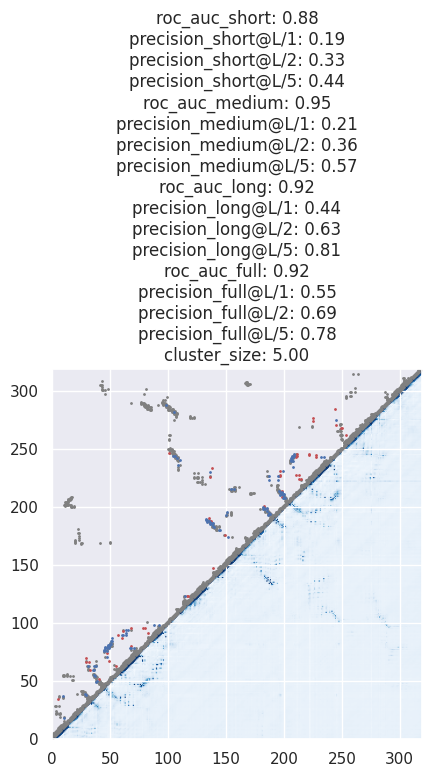

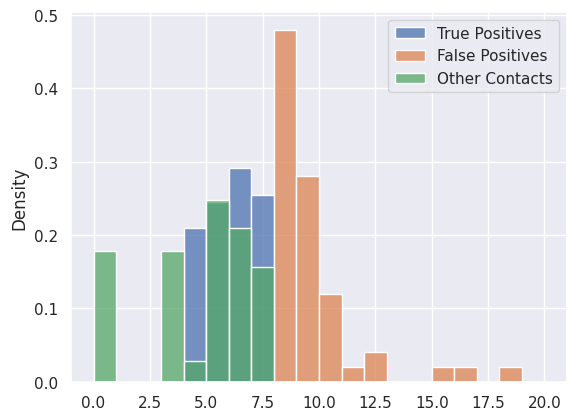

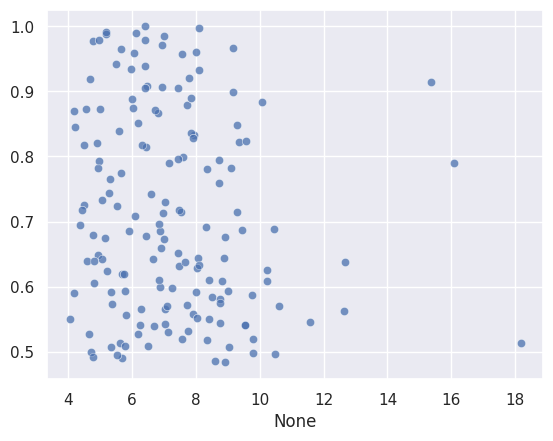

train_6OIP_A


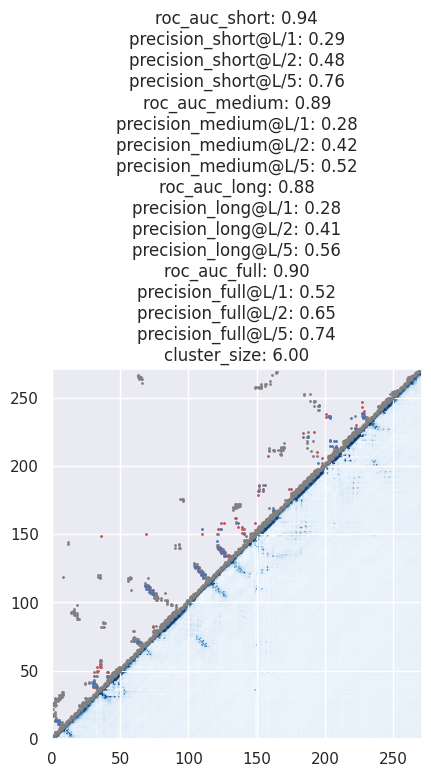

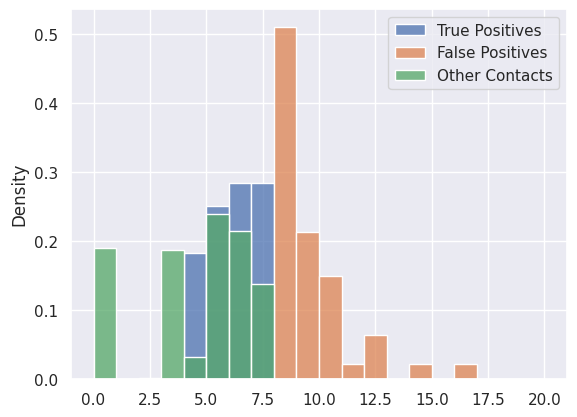

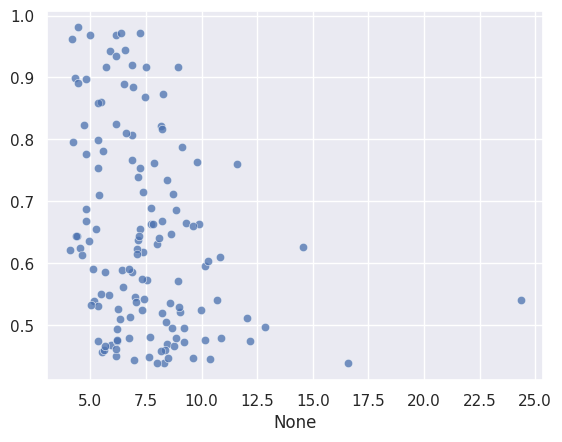

train_2Q17_B


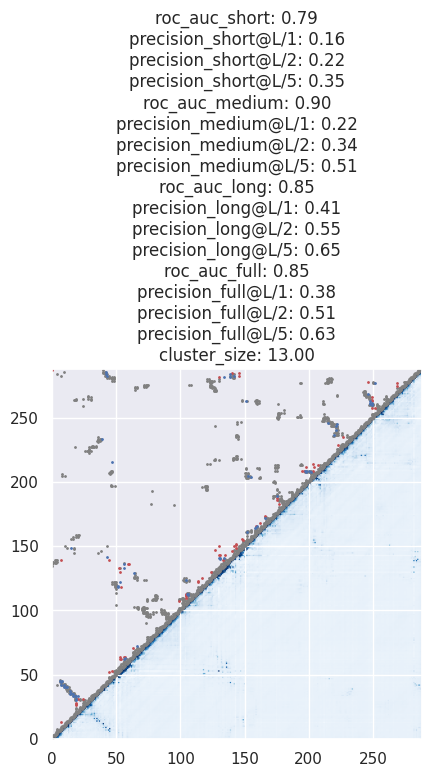

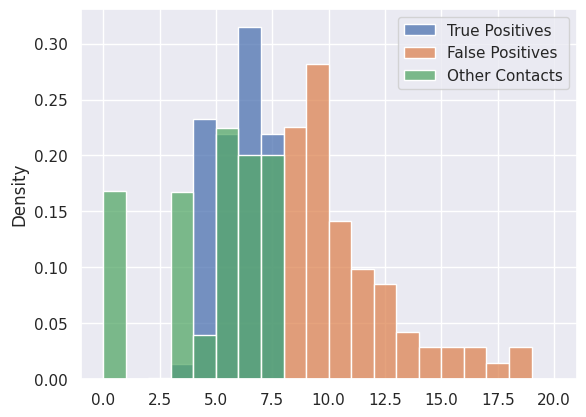

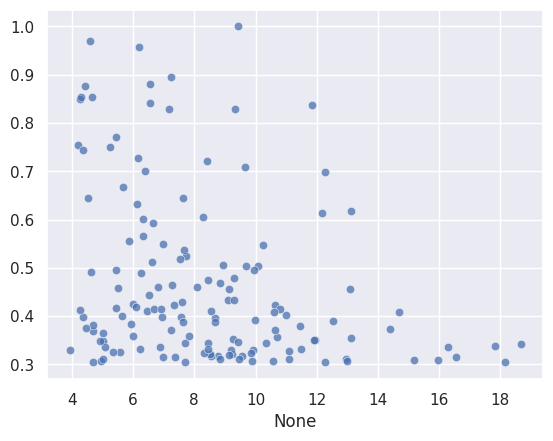

train_5JIA_I


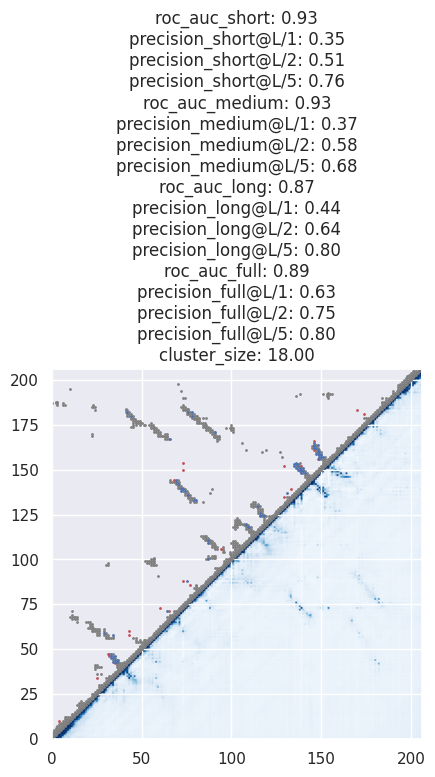

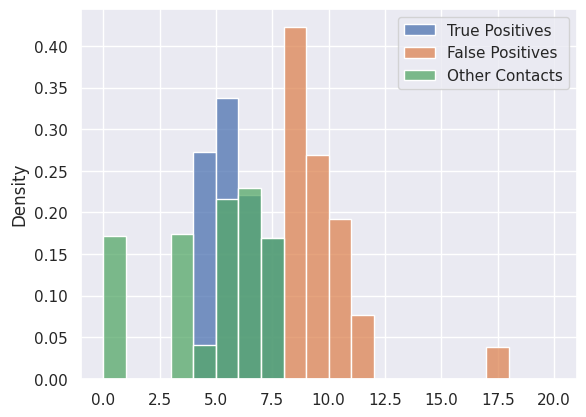

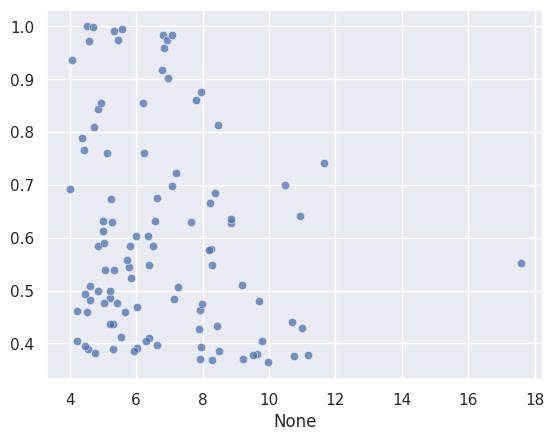

train_2DG1_F


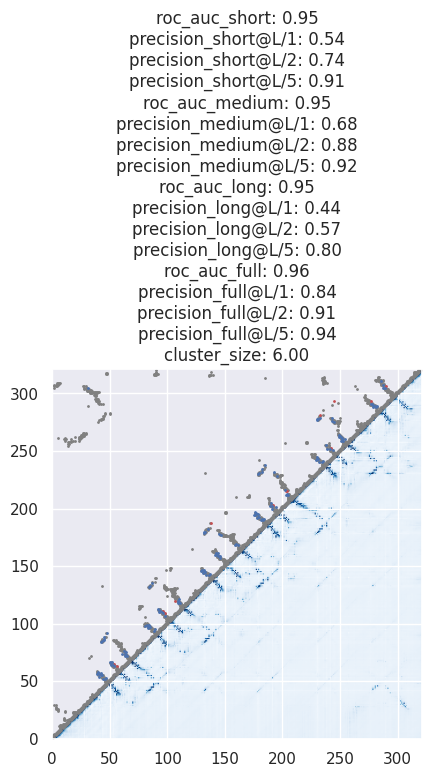

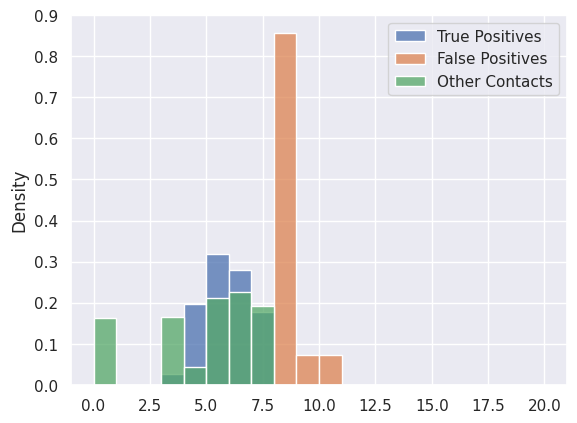

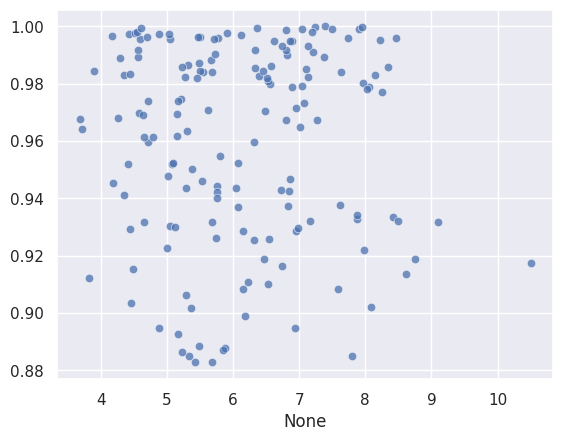

train_6AO3_D


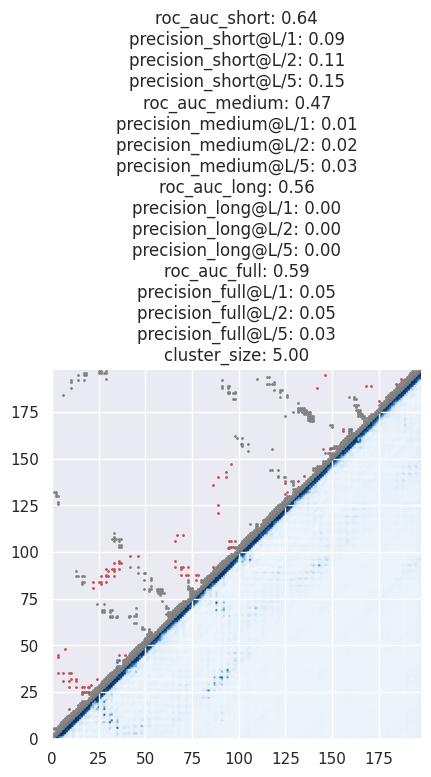

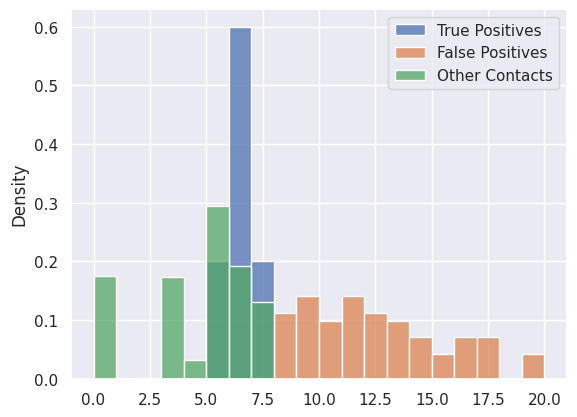

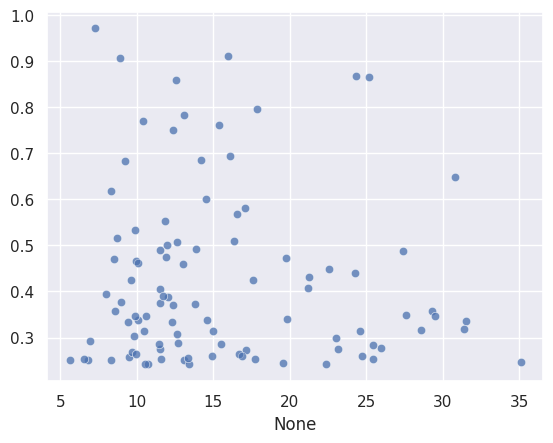

train_1HQZ_1


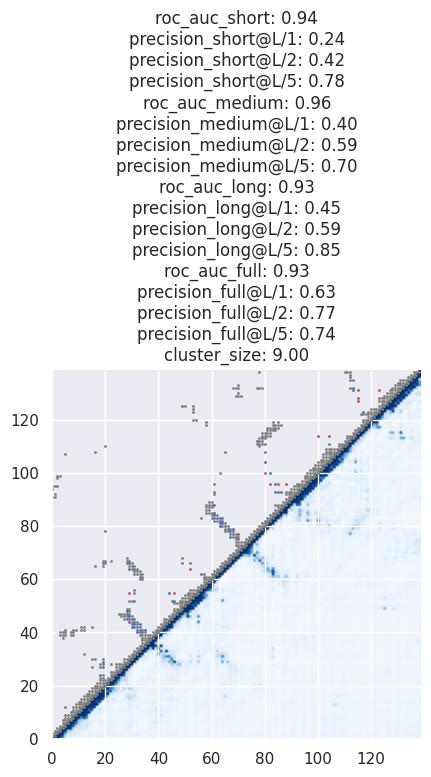

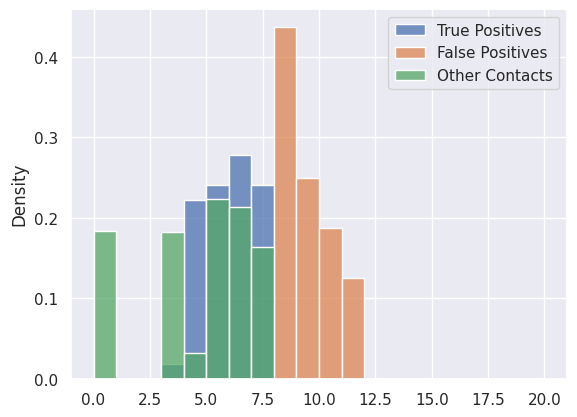

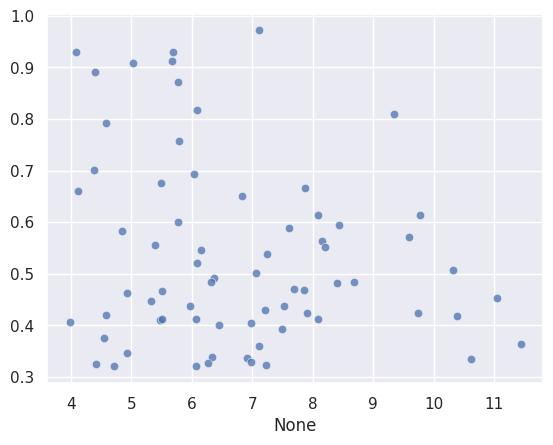

train_5C5S_C


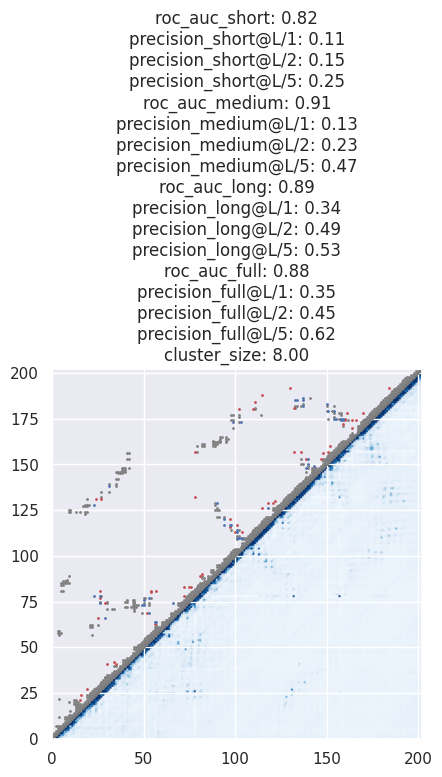

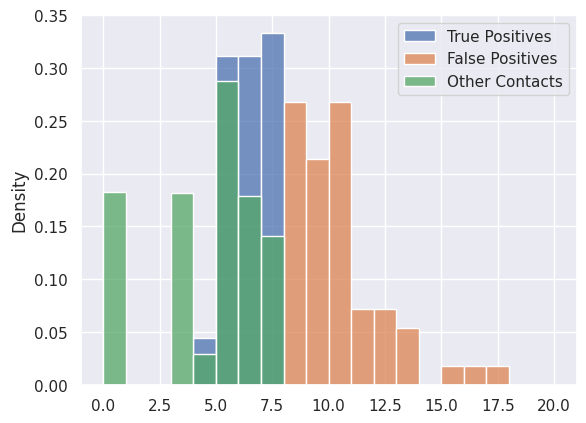

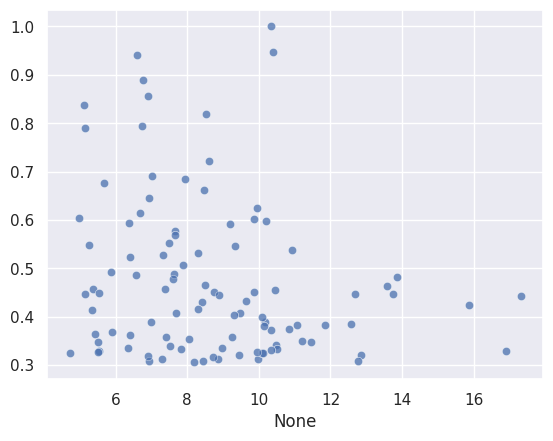

train_3GP5_A


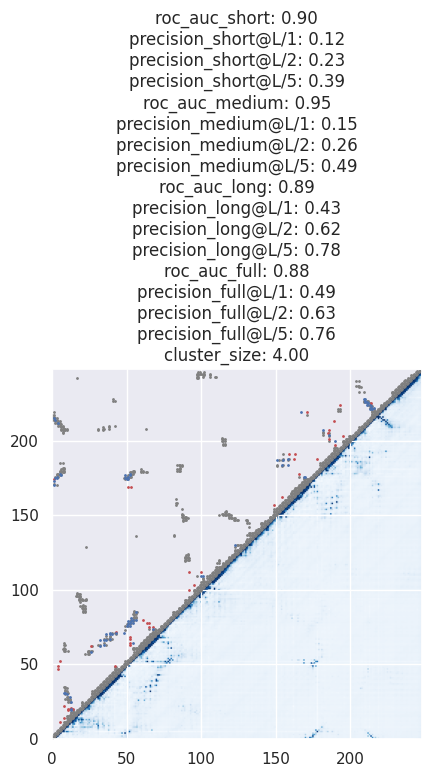

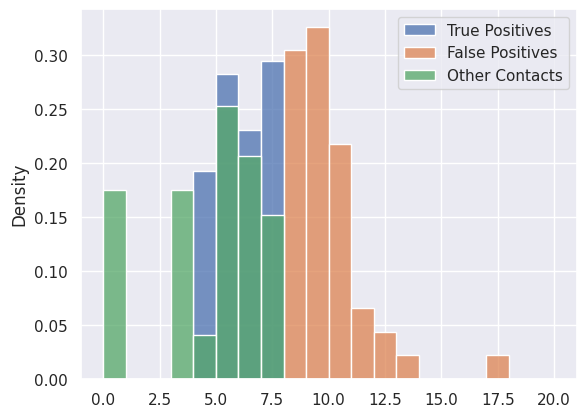

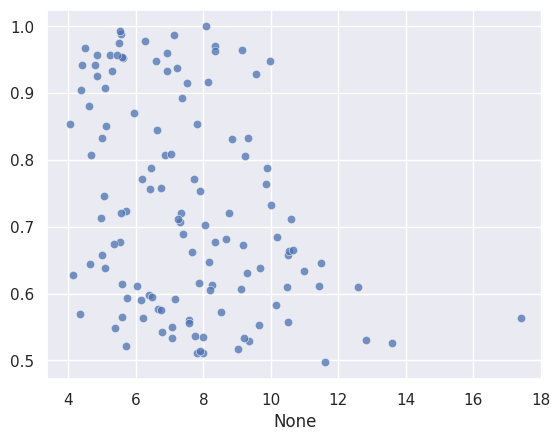

train_4DI8_B


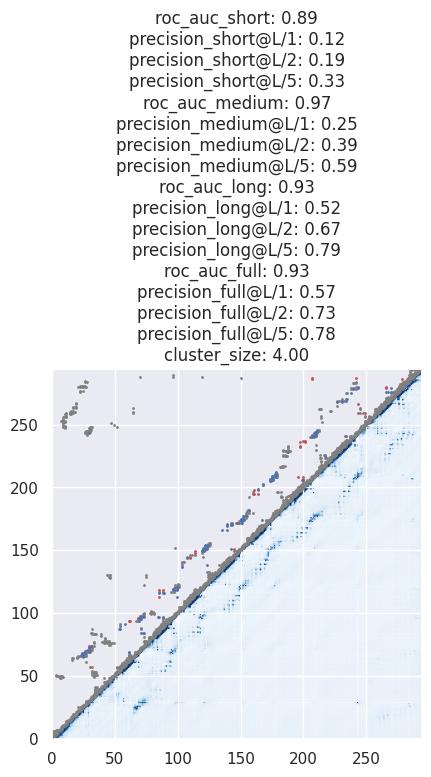

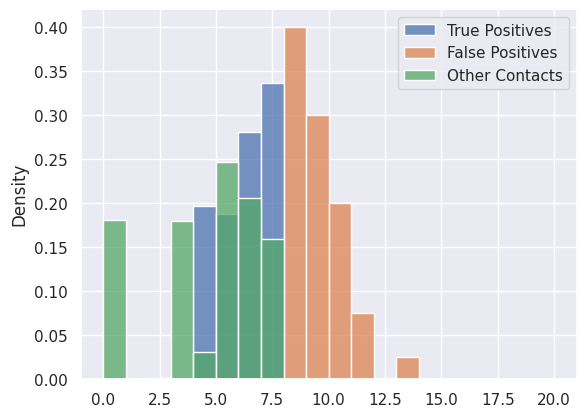

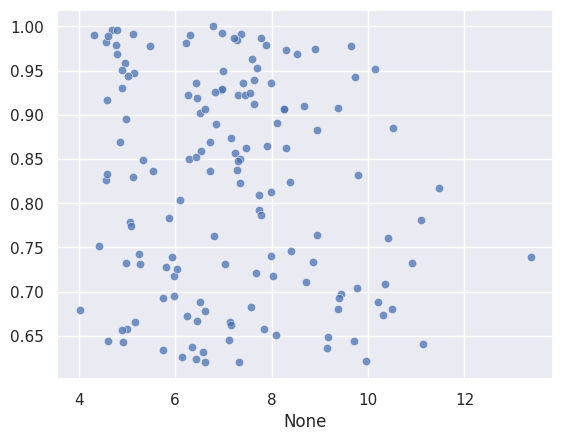

In [101]:
for id_, row in metrics.sample(10).iterrows():
    print(id_)
    plot_graphs(id_, row)


In [102]:
metrics.loc[metrics.index.str.contains('3LYW')]

,roc_auc_short,precision_short@L/1,precision_short@L/2,precision_short@L/5,roc_auc_medium,precision_medium@L/1,precision_medium@L/2,precision_medium@L/5,roc_auc_long,precision_long@L/1,precision_long@L/2,precision_long@L/5,roc_auc_full,precision_full@L/1,precision_full@L/2,precision_full@L/5,cluster_size
id,,,,,,,,,,,,,,,,,


In [77]:
clusters = pd.read_csv('../../pipeline/output/mmseqs/all_seqs_clust.tsv', sep='\t', header=None)
clusters.columns = ['cluster', 'id']
clusters.head()

,cluster,id
0,train_5ZZK_A,train_5ZZK_A
1,train_6BZQ_C,train_6BZQ_C
2,train_6BZQ_C,train_6BZQ_D
3,train_6BZQ_C,train_6BZA_A
4,train_6BZQ_C,train_6BZA_B


In [88]:
# get sizes of clusters for each sequence
cluster_sizes = clusters.groupby('cluster').size()
id_cluster_map = clusters.set_index('id')
id_cluster_map['size'] = cluster_sizes[id_cluster_map['cluster']].values

In [90]:
id_cluster_map.sort_values(by='size', ascending=False)

,cluster,size
id,,
train_7ATU_D,train_4C3F_A,141
train_7ATU_B,train_4C3F_A,141
train_7B8W_C,train_4C3F_A,141
train_7B8W_D,train_4C3F_A,141
train_7B8W_B,train_4C3F_A,141
...,...,...
train_4LN5_A,train_4LN5_A,1
train_4I6K_A,train_4I6K_A,1
train_1KQ3_A,train_1KQ3_A,1


In [92]:
metrics['cluster_size'] = id_cluster_map.loc[metrics.index]['size']

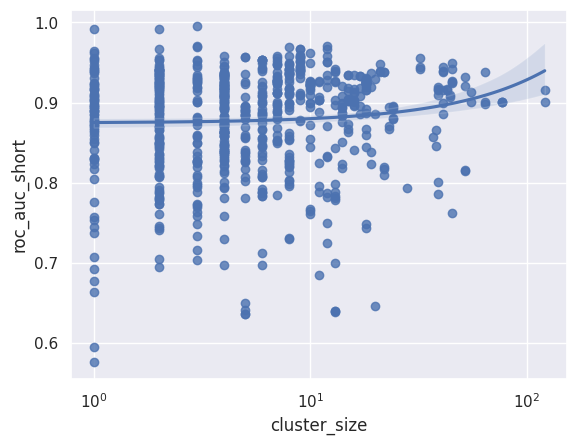

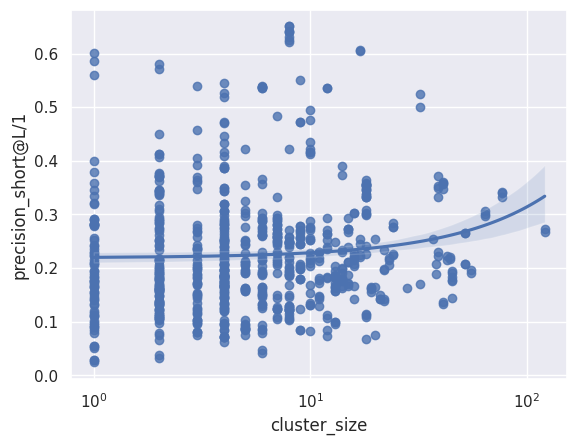

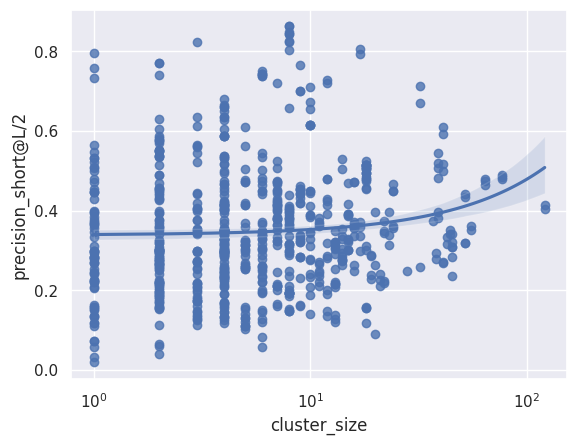

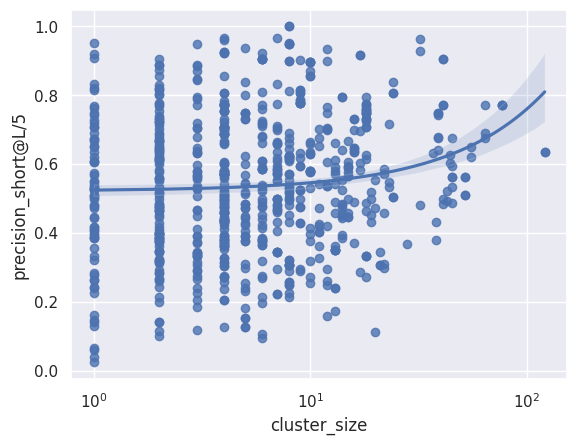

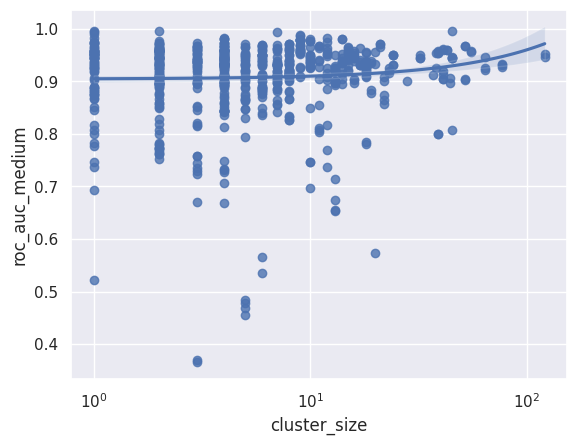

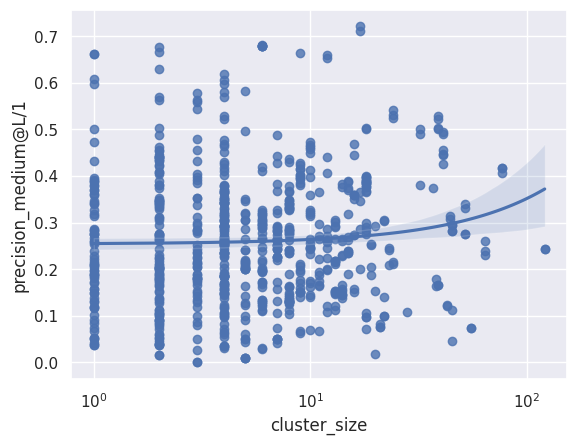

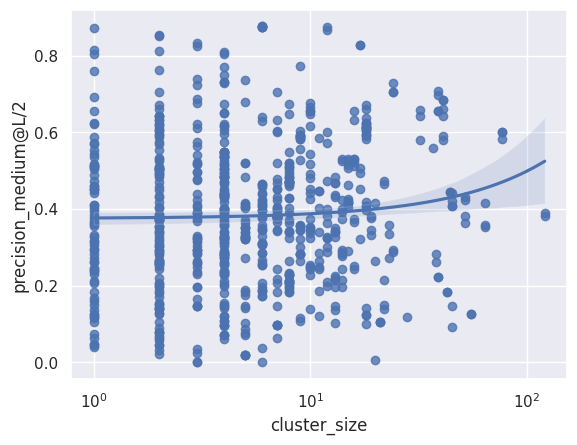

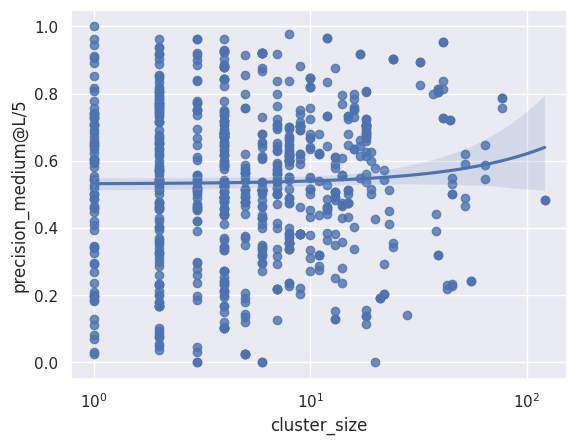

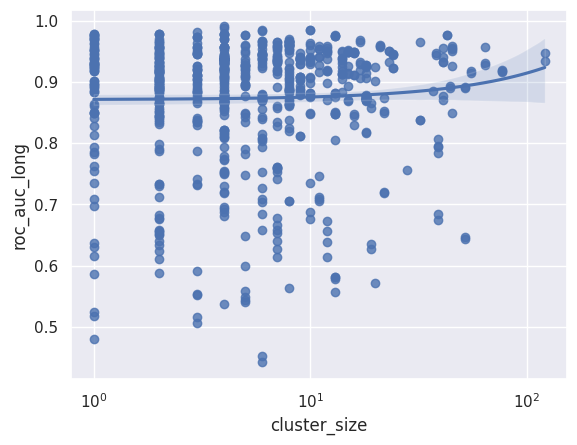

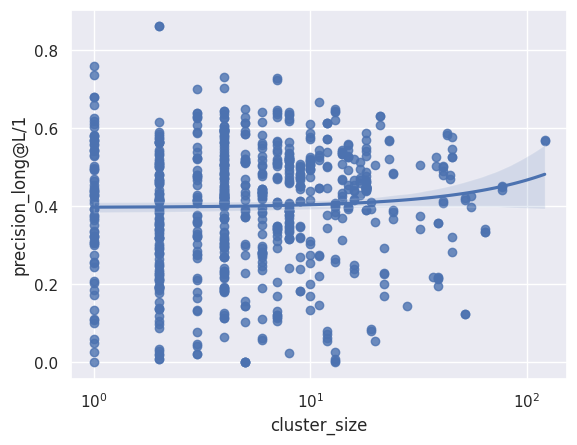

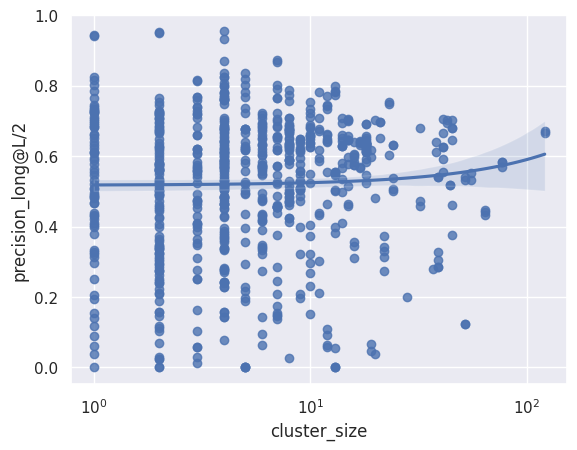

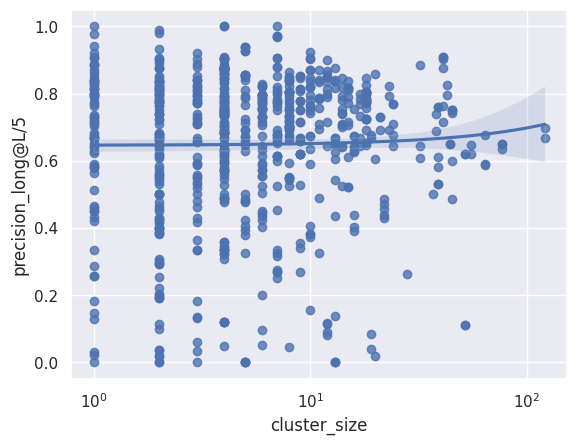

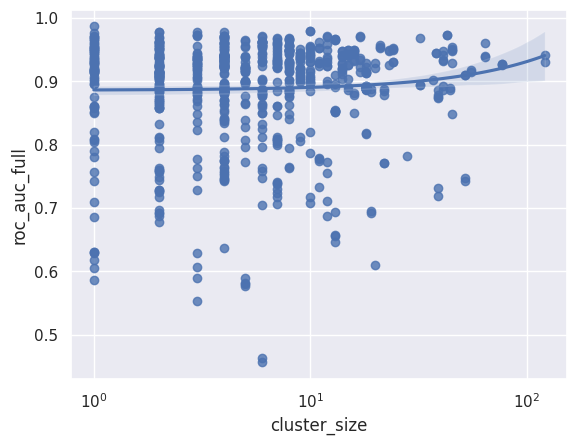

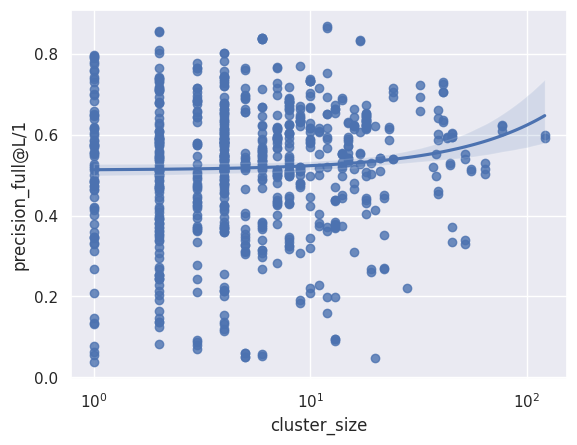

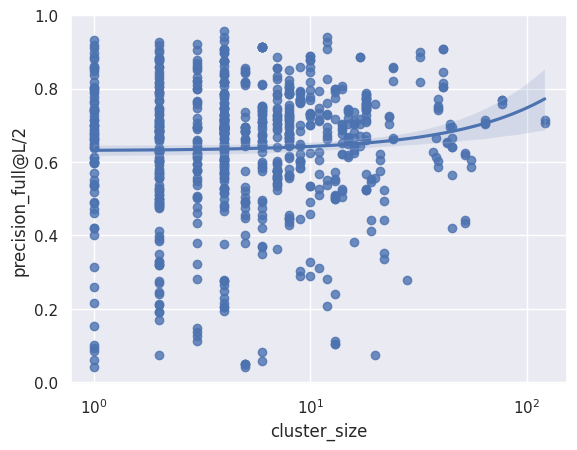

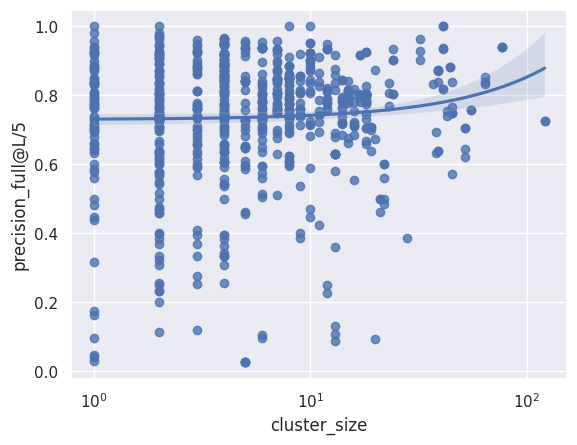

In [98]:
for col in metrics.columns:
    if col == 'cluster_size':
        continue
    sns.regplot(y=metrics[col], x=metrics['cluster_size'],)
    plt.xscale('log')
    plt.show()